# 03 - Multi-class Classification - Fitt Dataset Load from File

This notebook is intended to show the steps required to load a previously saved model and train it.
We use NTLK (the natural language toolkit) to process just the country_name geolocation records.  Other characteristics of this notebook include:

  * Fitt dataset used as it has the most number of country matches by IP geolocation lookup
  * Geolocation uses CSV from ip2location.com imported into a sqlite database

## Restore previoulsy saved df_sample DataFrame

In order to allow us to commence our training without having to repeat the previous data preraation steps, we will now load the df_sample dataframe using the pandas built-in from_json method.

In [1]:
from pathlib import Path
import pandas as pd
import os
from time import time
start = time()

cwd = Path.cwd()
file_path = os.path.join(cwd, 'saved_datasets', 'fitt_dataset_nodns.json' )
df_sample = pd.read_json(file_path)
end = time()
print(f"[+] Loaded pandas dataframe from disk in {(end-start):.2f} secs")

[+] Loaded pandas dataframe from disk in 2.06 secs


# the fun starts here...

Firstly, we will try to see if we can converge our model, we'll split the dataset as follows:

1. Training set (80%)
2. Test set (20%)
3. We have not set up a validation set as we will continue to validate the model against new captures


In [2]:
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
features = df_sample.drop('device_type', axis=1).values
features.shape

(94668, 32)

In [4]:
labels = df_sample['device_type'].values

encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)

In [5]:
encoded_labels

array([5, 3, 3, ..., 3, 3, 3])

In [6]:
dummy_labels = np_utils.to_categorical(encoded_labels)
dummy_labels.shape

(94668, 11)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(features, dummy_labels, test_size=0.2, random_state=42)

In [8]:
print(len(dummy_labels), len(Y_train), len(Y_test), sep='::')

94668::75734::18934


# Classification Problems

*A quick recap of the various hyper-parameters to be used in the model for each type of classification problem:*

**Binary Classification Problem**

A problem where you classify an example as belonging to one of two classes.

The problem is framed as predicting the likelihood of an example belonging to class one, e.g. the class that you assign the integer value 1, whereas the other class is assigned the value 0.

 - Output Layer Configuration: `One node with a sigmoid activation unit`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

**Multi-Class Classification Problem**

A problem where you classify an example as belonging to one of more than two classes.

The problem is framed as predicting the likelihood of an example belonging to each class.

 - Output Layer Configuration: `One node for each class using the softmax activation function`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

class ModelFactory():
 
    def __init__(self, *args, **kwargs):
        self.params = args
        print(f'[+] Initialised with params: {self.params}')
        if 'model_name' in kwargs:
            self.model_name = kwargs['model_name']

    def get_model(self):

        model = Sequential()
        model.add(Dense(self.params[0], input_dim=features.shape[1], activation='relu'))
        if len(self.params) > 1:
            for it in self.params[1:]:
                eval(f"model.add(Dense({it}, activation='relu'))")
                eval(f"model.add(Dropout(0.2))")
        model.add(Dense(dummy_labels.shape[1], activation='softmax'))
        model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                                verbose=1, mode='auto', restore_best_weights=True)
        
        return model

In [10]:
from pathlib import Path
cwd = Path.cwd()
NEEDS_TRAINING = False

if NEEDS_TRAINING:

    model_a = ( ModelFactory(64,128,64).get_model(), 'ModelA' )
    model_b = ( ModelFactory(32,64,32).get_model(),  'ModelB' )

    histories = []

    for my_mod in [model_a, model_b]: 
        mod, mod_name = my_mod
        history = mod.fit(X_train, Y_train, epochs=67, batch_size=10, shuffle=True, verbose=2)
        # Serialise model to json
        model_json = mod.to_json()
        filepath = os.path.join(
                                cwd,
                                'saved_models',
                                f'{mod_name}_multi_nodns.json'
                                )
        with open(filepath, "w") as json_file:
            json_file.write(model_json)

        # Serialize weights to HDF5
        filepath = os.path.join(
                            cwd,
                            'saved_models',
                            f'{mod_name}_multi_nodns.h5'
                            )
        mod.save_weights(filepath)
        loss, accuracy = mod.evaluate(X_test, Y_test, verbose=2)
        print(f'{my_mod[1]}: Loss = {loss}, Accuracy={accuracy}')
        histories.append([history, loss, accuracy])
else:
    pass

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (20,4)
LEGEND = False
for idx, hist_data in enumerate(histories, 1):
    history, loss, accuracy = hist_data
    # Plot training & validation accuracy values
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(history.history['accuracy'], color='black')
    plt.title(f'Model {idx} Accuracy: {(accuracy*100.0):.2f}', fontsize=16, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    if LEGEND: ax1.legend('Train', loc='upper left')

    # # Plot training & validation loss values
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(history.history['loss'], color='black')
    plt.title(f'Model {idx} Loss', fontsize=16, fontweight='bold')
    plt.ylabel('Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    if LEGEND: ax2.legend('Train', loc='upper left')
    plt.savefig(f'/home/ricdeez/uni/projects/iotnetlearn/multiclass{idx}_nodns.png', dpi=150)
    plt.show()

NameError: name 'histories' is not defined

## Loding model from file (if already trained)

In [12]:
from keras.models import model_from_json
import os
import json

In [13]:
# load json and create model
import os
from pathlib import Path
cwd = Path.cwd()

json_file = open(
                os.path.join(
                    cwd,
                    'saved_models',
                    'ModelA_multi_nodns.json'
                ), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join(cwd, 'saved_models', 'ModelA_multi_nodns.h5'))
print("[+] Loaded model from disk")


[+] Loaded model from disk


In [14]:
# These functions were adapted from:
# Jeff Heaton, McKelvey School of Engineering, Washington University in St. Louis

from sklearn.metrics import roc_curve, auc


def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc(pred,y):
    plt.rcParams["figure.figsize"] = (20,0)
    plt.rcParams["figure.dpi"] = 300
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig(f'/home/ricdeez/uni/projects/iotnetlearn/roc.png', dpi=150)
    plt.show()


## Calculation of Classification Accuracy

Accuracy refers to the number of rows in our dataset where the model predicted the target class.  Accuracy is only used for classification, not regression.

\begin{align}
accuracy = \frac{c}{N}
\end{align}

Where:
 * c is the number correct, and
 * N is the size of the evaluated set
 
Keras returns the probability percentage for each class.  We'll change these into actual model predictions with argmax.

In [15]:
import numpy as np
pred = loaded_model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(Y_test, axis=1)
y_test

array([9, 0, 9, ..., 4, 3, 9])

In [16]:
# Adapted from:
# Jeff Heaton, McKelvey School of Engineering, Washington University in St. Louis
from sklearn import metrics

y_compare = np.argmax(Y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.8974331889722192


Confusion matrix, without normalization
[[1677    0    0    7    0    6    0    0    0  726    0]
 [   0    0    0    1    0    0    0    0    0    0    0]
 [   0    0    0    2    0    0    0    0    0    0    0]
 [  24    0    0 4262   27  331    0    1    0    1    0]
 [   1    0    0   11 2937    0    0    0    0    0    0]
 [   5    0    0  597    2  906    0    5    0    2    1]
 [   1    0    0    5    0    0    0    1    0    0    0]
 [  77    0    0   58    0   14    0   44    0    0    0]
 [   0    0    0   23    0    0    0    0    0    0    0]
 [   0    0    0   13    0    0    0    0    0 5907    0]
 [   0    0    0    0    0    0    0    0    0    0 1259]]
Normalized confusion matrix
[[6.94e-01 0.00e+00 0.00e+00 2.90e-03 0.00e+00 2.48e-03 0.00e+00 0.00e+00
  0.00e+00 3.00e-01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 

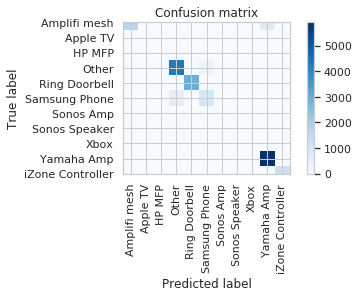

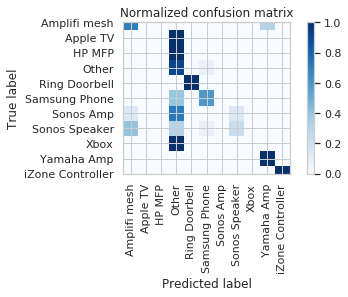

In [17]:
# Adapted from
# Jeff Heaton, McKelvey School of Engineering, Washington University in St. Louis
dummies = pd.get_dummies(df_sample['device_type'])
device_types = dummies.columns
products= device_types

import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, products)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, title='Normalized confusion matrix')
plt.savefig(f'/home/ricdeez/uni/projects/iotnetlearn/confusion_matrix_multi.png', dpi=300)
plt.show()
